In [13]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

import h5py
import pickle
import pycolmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dataset = Path('./')
images = Path(dataset / 'img/')
outputs = Path(dataset /'outputs/')
# !rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

2 images


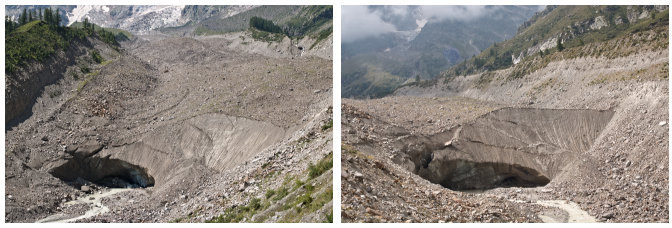

In [8]:
references = [p.relative_to(images).as_posix() for p in (images).iterdir()]
print(len(references), "images")
plot_images([read_image(images / r) for r in references[:4]], dpi=50)

In [9]:
# extract_features.main(feature_conf, images, image_list=references, feature_path=features)
# pairs_from_exhaustive.main(sfm_pairs, image_list=references)
# match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

In [5]:
# model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

In [10]:
# Retrieve matched features with SG
fname = Path(dataset / 'IMG_0520_IMG_2131_features.pickle')
with open(fname, 'rb') as f:
    mfeats = pickle.load(f)
# print(mfeats)

BUILD HDF5 DATASETS

In [11]:
# Build hdf5 features datasets
from hloc.utils.io import (list_h5_names, get_matches, get_keypoints, find_pair) 
from hloc.utils.parsers import names_to_pair
import h5py
 
name0 = 'IMG_0520.tif'
name1 = 'IMG_2180.tif'
pair = names_to_pair(name0, name1)

data = {'keypoints': mfeats[0]['mkpts0'],
       'descriptors': mfeats[0]['descr0'], 
       'scores': mfeats[0]['scores0']} 
name = name0
with h5py.File(features, 'a') as fd:
    if name in fd:
        del fd[name]
    grp = fd.create_group(name)
    for k, v in data.items():
        grp.create_dataset(k, data=v)

data = {'keypoints': mfeats[0]['mkpts1'],
       'descriptors': mfeats[0]['descr1'], 
       'scores': mfeats[0]['scores1']} 
name = name1
with h5py.File(features, 'a') as fd:
    if name in fd:
        del fd[name]
    grp = fd.create_group(name)
    for k, v in data.items():
        grp.create_dataset(k, data=v)
        
# # Read again saved file for proof
# with h5py.File(str(features), 'r') as hfile:
#     # print(list(hfile.keys()))
#     # data = hfile[key for key in list(hfile.keys())]
#     kpts0  = hfile[name0]['keypoints'].__array__()
#     desc0  = hfile[name0]['descriptors'].__array__()
#     scor0  = hfile[name0]['scores'].__array__()

# Build hdf5 matching datasets
matchArray = []
matchScores = []
npts = len(mfeats[0]['mkpts1'])
for i in range(0, npts):
    matchArray.append(i)
    matchScores.append(1)
                
pair = names_to_pair(name0, name1)
with h5py.File(outputs/"matches.h5",'a') as fd:
    if pair in fd:
        del fd[pair]
    grp = fd.create_group(pair)
    grp.create_dataset('matches0', data=matchArray)
    grp.create_dataset('matching_scores0', data=matchScores)

In [12]:
# print(sfm_dir)
# print(images)
# print(sfm_pairs)
# print(features)
# print(matches)

In [14]:
# Run reconstruction
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references, verbose = True,  camera_mode=pycolmap.CameraMode.PER_IMAGE)

[2022/06/03 16:25:47 hloc INFO] Found 1 pairs.
[2022/06/03 16:25:47 hloc WARNING] The database already exists, deleting it.
[2022/06/03 16:25:47 hloc INFO] Creating an empty database...
[2022/06/03 16:25:47 hloc INFO] Importing images into the database...
[2022/06/03 16:25:48 hloc INFO] Importing features into the database...


  0%|          | 0/2 [00:00<?, ?it/s]

[2022/06/03 16:25:48 hloc INFO] Importing matches into the database...


  0%|          | 0/1 [00:00<?, ?it/s]

[2022/06/03 16:25:48 hloc INFO] Performing geometric verification of the matches...



Custom feature matching

Matching block [1/1] in 0.492s
Elapsed time: 0.008 [minutes]


[2022/06/03 16:25:48 hloc INFO] Running 3D reconstruction...



Loading database

Loading cameras... 2 in 0.001s
Loading matches... 1 in 0.001s
Loading images... 2 in 0.001s (connected 2)
Building correspondence graph... in 0.001s (ignored 0)

Elapsed time: 0.000 [minutes]


Finding good initial image pair


Initializing with image pair #1 and #2


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.346927e+03    0.00e+00    2.00e+06   0.00e+00   0.00e+00  1.00e+04        0    5.43e-03    1.62e-02
   1  6.174825e+03    2.17e+03    2.14e+06   1.22e+02   9.27e-01  2.64e+04        1    1.13e-02    2.84e-02
   2  6.792279e+03   -6.17e+02    2.14e+06   2.76e+02  -3.89e-01  1.32e+04        1    5.40e-03    3.45e-02
   3  5.384847e+03    7.90e+02    2.65e+06   1.55e+02   7.95e-01  1.66e+04        1    1.18e-02    4.71e-02
   4  4.645120e+03    7.40e+02    3.05e+06   1.64e+02   7.46e-01  1.89e+04        1    1.38e-02    6.14e-02
   5  3.931678e+03    7.13e+02    2.82

[2022/06/03 16:25:53 hloc INFO] Reconstructed 1 model(s).
[2022/06/03 16:25:53 hloc INFO] Largest model is #0 with 2 images.
[2022/06/03 16:25:53 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 2
	num_cameras = 2
	num_points3D = 2530
	num_observations = 5060
	mean_track_length = 2
	mean_observations_per_image = 2530
	mean_reprojection_error = 0.506564
	num_input_images = 2


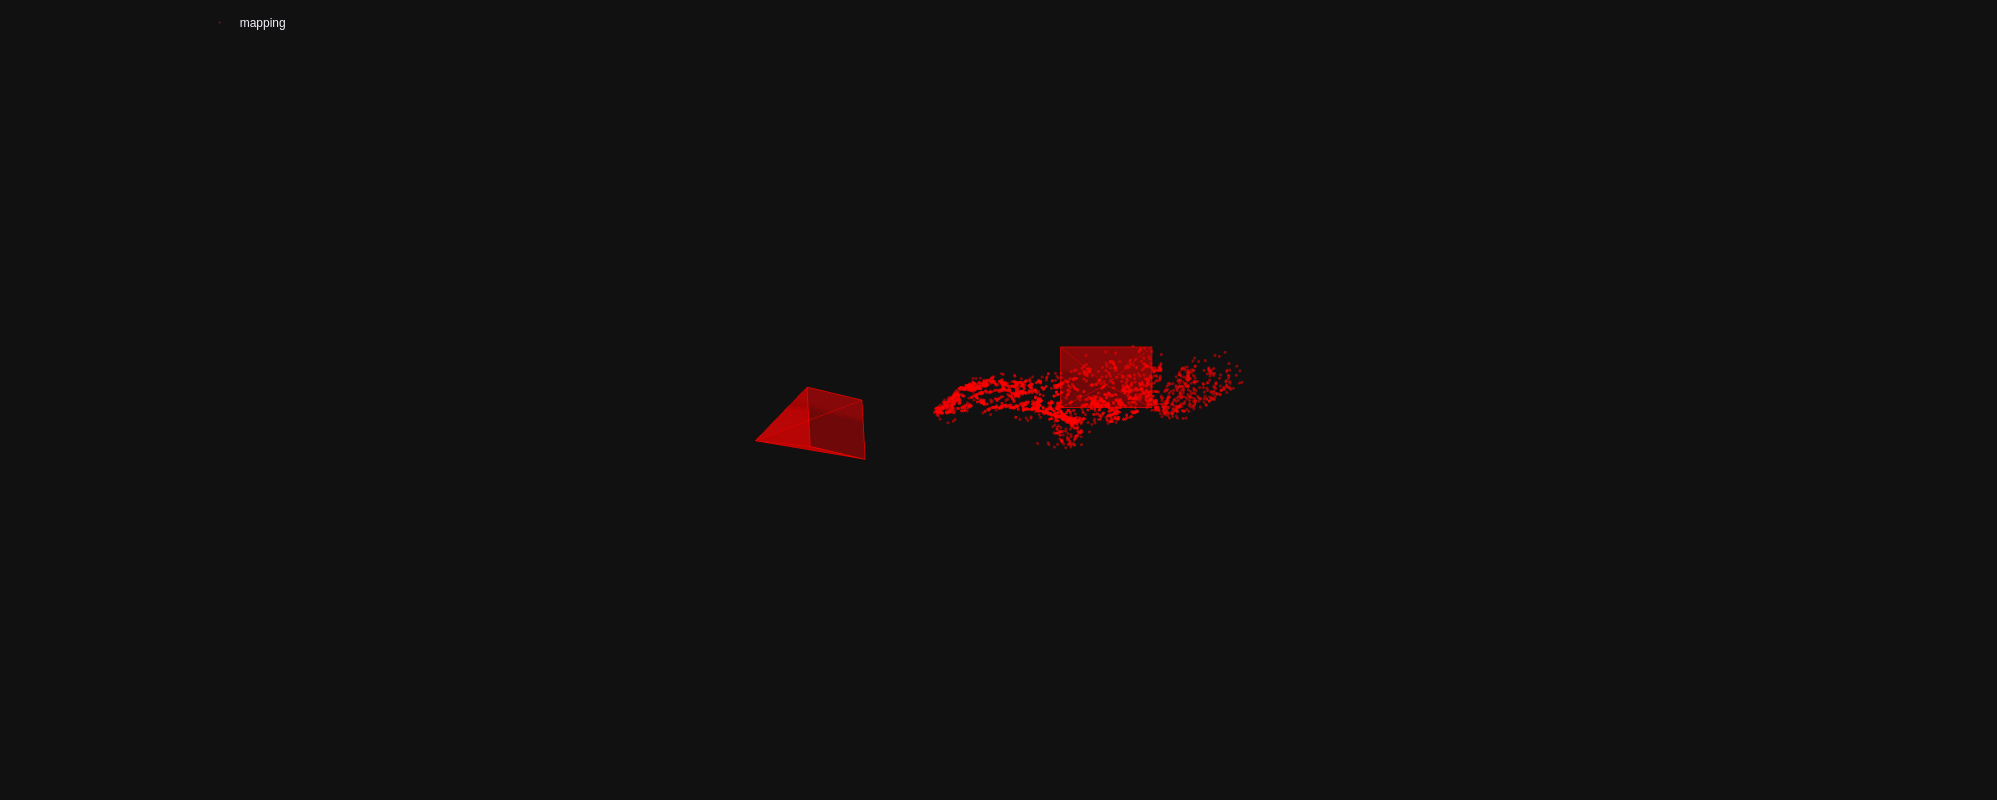

In [16]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

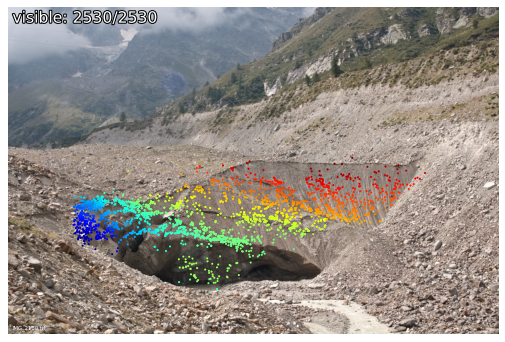

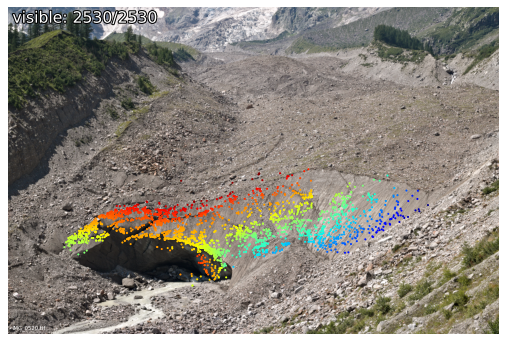

In [17]:
visualization.visualize_sfm_2d(model, images, color_by='depth', n=2)

In [1]:
pycolmap.CameraMode.__members__.keys()

dict_keys(['AUTO', 'SINGLE', 'PER_FOLDER', 'PER_IMAGE'])

In [18]:
for image_id, image in model.images.items():
    print(image_id, image)
# for point3D_id, point3D in reconstructionObj.points3D.items():
#     print(point3D_id, point3D)

for camera_id, camera in model.cameras.items():
    print(camera_id, camera)


1 <Image 'image_id=1, camera_id=1, name="IMG_0520.tif", triangulated=2530/2530'>
2 <Image 'image_id=2, camera_id=2, name="IMG_2180.tif", triangulated=2530/2530'>
1 <Camera 'camera_id=1, model=SIMPLE_RADIAL, width=6000, height=4000, num_params=4'>
2 <Camera 'camera_id=2, model=SIMPLE_RADIAL, width=6000, height=4000, num_params=4'>
